# SEGMENTING AND CLUSTERING NEIGHBORHOODS OF TORONTO

### 1 Importing Libraries

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium                      # map rendering library
import numpy as np                 # for efficient numerical operations
import pandas as pd                # for data frame analytics
import requests                    # for pulling html pages and creating html documents
import matplotlib as mpl           # visualization library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup      # for scraping html documents
from sklearn.cluster import KMeans # for clustering

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


### 2 Parsing the Wikipedia page on Toronto postal codes

By means of the <i>requests</i> library which has been loaded above, the link provided in the description of the assignment can be employed to retrieve the html page pointed to be that link. This is acchieved via the <i>requests.get()</i> function. Once the html page is retrieved the underlying html document stored in the <i>text</i> attribute of the page object. Lastly, this hmtl document is parsed by means of the <i>BeautifulSoup</i> library.

In [2]:
html_link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_page = requests.get(html_link)
html_doc = html_page.text
soup = BeautifulSoup(html_doc,'html.parser')

### 3 Scraping the html document

#### 3.1 Searching the postal code table in the html document and creating a dataframe from it
Firstly, the soup object is searched for the table by means of the <i>find()</i> function and specifying the html tag <i>table</i>. With the help of that same function the rows (html tagged <i>tr</i>) are then extracted from the table, and headers (html tagged <i>th</i>) are extracted from the first row. These headers, together with the number of rows are employed to create a raw pandas dataframe <i>table_df</i> which contains all rows of the table found on the wikipedia page.

In [3]:
table = soup.find('table')                                                   # searching for table in html document
rows = table.findAll('tr')                                                   # gathering all rows in that table
header = rows[0].findAll('th')                                               # gathering all column headers in first row of the table
col_num = len(header)                                                        # number of columns equals number of headers found and hence the length of the header object
row_num = len(rows)-1                                                        # number of rows equals number of table rows minus one since first row did contain column headers

columns = list()                                                             # writing column headers into a list
for c in range(col_num):
    if c != col_num-1:
        columns.append(header[c].string.lower())
    else:
        columns.append(header[c].string[:-1].lower())

table_df = pd.DataFrame(columns=columns,index=range(row_num))                # creating a pandas data frame with column names defined by the list of column headers and index defined by number of rows

for i in range(row_num):                                                     # filling the table row by row
    row = rows[i+1].findAll('td')
    for c in range(col_num):
        table_df.iloc[i,c] = row[c].string
        if table_df.iloc[i,c] == None:                                       # the entry of the wikipedia table may have been a string or a hyperlink. If the latter the td object does not provide the string
            table_df.iloc[i,c] = row[c].a.string                             # but its child 'a' does

for i in table_df.index:                                                     # removing line breaks
    if table_df.loc[i,'neighbourhood'][-1:] == '\n':
        table_df.loc[i,'neighbourhood']=table_df.loc[i,'neighbourhood'][:-1]
        
table_df.head()

,postcode,borough,neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### 3.2 Manipulating the raw dataframe
Next, those rows of the raw dataframe <i>table_df</i> data frame who have no borough assigned, are dropped. Next, if among the remaining entries the neighborhood is not assigned, the neighborhood name will be the same as the borough name.

In [4]:
for i in table_df.index:
    if table_df.loc[i,'borough'] == 'Not assigned':
        table_df = table_df.drop(i,axis=0)
    elif table_df.loc[i,'neighbourhood'] == 'Not assigned':
        table_df.loc[i,'neighbourhood'] = table_df.loc[i,'borough']
        
table_df.head()

,postcode,borough,neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


#### 3.3  Creating a clean postal code dataframe from the raw data frame
Lastly, from the raw dataframe <i>table_df</i> the unique postal codes are collected and employed to create a clean dataframe <i>code_df</i> which lists codes, borough names and all associated neighborhoods.

In [5]:
code_list = list(table_df['postcode'].unique())
code_df = pd.DataFrame(columns=columns,index=range(len(code_list)))

for i in code_df.index:
    code = code_list[i]
    sub_df = table_df[table_df['postcode']==code]
    hood_string = ''
    for j in range(sub_df.shape[0]):
        hood_string = hood_string + sub_df.loc[sub_df.index[j],'neighbourhood'] + ','
    hood_string = hood_string[:-2]
    code_df.loc[i,'postcode'] = code
    code_df.loc[i,'borough'] = sub_df.loc[sub_df.index[0],'borough']
    code_df.loc[i,'neighbourhood'] = hood_string
    
code_df.sort_values('postcode',inplace=True)
code_df.reset_index(inplace=True)
code_df.drop('index',axis=1,inplace=True)
    
code_df.head()

,postcode,borough,neighbourhood
0,M1B,Scarborough,"Rouge,Malver"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Unio"
2,M1E,Scarborough,"Guildwood,Morningside,West Hil"
3,M1G,Scarborough,Wobur
4,M1H,Scarborough,Cedarbra


Finally, the number of rows of the <i>code_df</i> dataframe can be infered from its <i>shape[0]</i> object.

In [6]:
print('The Toronto postal code dataframe contains {} boroughs and {} postal codes.'.format(len(code_df['borough'].unique()),code_df.shape[0]))

The Toronto postal code dataframe contains 11 boroughs and 103 postal codes.


### 4 Geolocating and mapping Toronto neighborhoods

#### 4.1 Assigning latitude and longitude

The csv file containing the georeferences for the Toronto postal codes (provided by coursera) is loaded into a dataframe.

In [7]:
geodata_df = pd.read_csv('https://cocl.us/Geospatial_data') # loading geodata in a pandas dataframe
geodata_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


The <i>geodata_df</i> dataframe is then employed in order to look up the georeferences for the postal codes listed in the <i>code_df</i> dataframe.

In [8]:
code_df['latitude'] = ''                                                               # adding latitude column to code_df data frame
code_df['longitude'] = ''                                                              # adding longitude column to code_df data frame

for i in code_df.index:
    code = code_df.loc[i,'postcode']
    code_df.loc[i,'latitude'] = geodata_df[geodata_df['Postal Code']==code].iloc[0,1]  # assigning latidtude by reduceing geodata_df to the entry matching the postal code and then calling its latitude column 1
    code_df.loc[i,'longitude'] = geodata_df[geodata_df['Postal Code']==code].iloc[0,2] # assigning longidtude by reduceing geodata_df to the entry matching the postal code and then calling its longitude column 2
    
code_df.head()

,postcode,borough,neighbourhood,latitude,longitude
0,M1B,Scarborough,"Rouge,Malver",43.8067,-79.1944
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Unio",43.7845,-79.1605
2,M1E,Scarborough,"Guildwood,Morningside,West Hil",43.7636,-79.1887
3,M1G,Scarborough,Wobur,43.771,-79.2169
4,M1H,Scarborough,Cedarbra,43.7731,-79.2395


Once we have the georeferences, we can look at the distances between the postal code areas. This will help us later to determine the radius within which we look up venues from foursquare. To this end we calculate the distance between all pairs of code areas (i.e., 103x102/2 and hence about 5000 distances) and plot the cumulative histogram in order to see how many distances fall within a given radius.

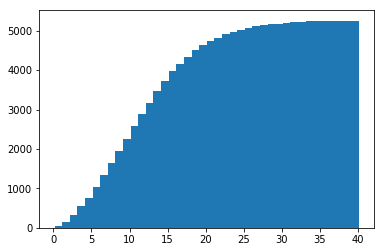

In [9]:
R = 6373.0 # earth radius
dist_list = [] # allocating empty array to store postcode area distances in

for i in range(len(code_df.index)):
    for j in range(len(code_df.index)):
        if j>i  :
            lat_i = np.radians(code_df.loc[code_df.index[i],'latitude'])
            lon_i = np.radians(code_df.loc[code_df.index[i],'longitude'])
            lat_j = np.radians(code_df.loc[code_df.index[j],'latitude'])
            lon_j = np.radians(code_df.loc[code_df.index[j],'longitude'])
            dlon = lon_i-lon_j
            dlat = lat_i-lat_j
            a = np.sin(dlat/2)**2+np.cos(lat_i)*np.cos(lat_j)*np.sin(dlon/2)**2
            c = 2*np.arctan(np.sqrt(a)/np.sqrt(1-a))
            dist = R*c
            dist_list.append(dist)

plt.hist(np.array(dist_list),cumulative=True,bins=40)
plt.show()

As can be seen above, the maximum distance is 40km and about a 100 mutual distances fall are below 2km.

#### 4.2 Mapping the neighborhoods

In [10]:
toronto_map = folium.Map(location=[code_df.latitude.mean(),code_df.longitude.mean()],zoom_start=12)

for lat,lng,borough,code in zip(code_df['latitude'],code_df['longitude'],code_df['borough'],code_df['postcode']):
    label = '{}, {}'.format(code,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7,parse_html=False).add_to(toronto_map)  
    
toronto_map

### 5 Exploring Toronto neighborhoods via the Foursquare API

#### 5.1 Querying nearby venues

In order to make use of the Foursquare API, the credentials need to be transmitted. Also, we define the function <i>GetVenues</i> that performs the query of venues for a list of names and corresponding latitudes and longitudes. The standard geographical search radius is set to 1km and the number of venues listed is set to 500.

In [11]:
CLIENT_ID = '41HXMY040EFZ5BW2JCZHSGGPG4ZBNJ1BVDCG2XHIE2FO5Y5B'     # Foursquare ID
CLIENT_SECRET = 'GZNPZKZ2VCTSQ3BW2SYFAH2CZ0VAQYXLS1UW1RGF1BOFTFIQ' # Foursquare Secret
VERSION = '20180605'                                               # Foursquare API version

def GetVenues(names,latitudes,longitudes,radius=1000,limit=500):
    
    venues_list=[]
    for name,lat,lng in zip(names,latitudes,longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
              .format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,limit)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(name,lat,lng,\
                             v['venue']['name'],\
                             v['venue']['location']['lat'],\
                             v['venue']['location']['lng'],\
                             v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['postcode','psotcode latitude','postcode longitude','venue','venue latitude','venue longitude','venue category']
    
    return(nearby_venues)

Next the list of postcodes and associated GPS coordinates is input to the function which then outputs the dataframe <i>toronto_veues</i> whose shape we check.

In [12]:
toronto_venues = GetVenues(names=code_df['postcode'],latitudes=code_df['latitude'],longitudes=code_df['longitude'])
print('{} Toronto venues found for {} postcode areas and in {} unique categories.'\
      .format(toronto_venues.shape[0],len(toronto_venues['postcode'].unique()),len(toronto_venues['venue category'].unique())))

4870 Toronto venues found for 102 postcode areas and in 332 unique categories.


In [13]:
toronto_venues.head()

,postcode,psotcode latitude,postcode longitude,venue,venue latitude,venue longitude,venue category
0,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
2,M1B,43.806686,-79.194353,Harvey's,43.800106,-79.198258,Fast Food Restaurant
3,M1B,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
4,M1B,43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant


Since 300+ venue categories generate an extremely high-dimensional space in which to cluster, we reduce those to 10 super categories and hence a 10-dimensional space supporting the clusters. This will increase reliability as well as interpretability of the results. The 10 super catefories are <i>restaurant, café, nightlife, mobility, store, recreation, health, culture, accomodation</i> and <i>other</i>. Categories are assigned to super categories by means of pre-selected key-words.

In [14]:
toronto_venues['super category'] = ''
cafe_list      = ['creperie','coffee','café','tea','cafeteria','deli']
restau_list    = ['restaurant','diner','joint','food','spot','place','house','buffet','bistro']
nightlife_list = ['bar','lounge','pub','club','brewery']
transport_list = ['bus','airport','train','rental','rail','metro','cable car','harbor','boat','travel','garage','auto','gas']
store_list     = ['store','shop','market','butcher','bakery','laundry','garden center','boutique','grocery','storage']
sports_list    = ['martial','gym','playground','park','sport','yoga','hockey','soccer','skating','stadium','bowling','pool','badminton','golf','outdoor','tennis','lake',\
                  'recreation','beach','basketball','ski','community','moving','baseball','curling','lookout','dance','gaming','track','farm','garden','river','field','zoo',\
                  'aquarium','pilates','tree']
health_list    = ['pharmacy','medical','massage','nail','chiropractor','health','tanning','spa']
culture_list   = ['entertainment','theater','museum','arts','concert','gallery','music','exhibit','photography','intersection','plaza','road','bridge','neighborhood',\
                  'historic','cemetery','church','fountain','monument','castle','tunnel','college','library','school','university']
hotel_list     = ['hotel','hostel']

for i in toronto_venues.index:
    category = toronto_venues.loc[i,'venue category'].lower()
    if   any([key in category for key in restau_list]):        toronto_venues.loc[i,'super category'] = 'restaurant'
    elif any([key in category for key in cafe_list]):          toronto_venues.loc[i,'super category'] = 'café'
    elif any([key in category for key in nightlife_list]):     toronto_venues.loc[i,'super category'] = 'nightlife'
    elif any([key in category for key in transport_list]):     toronto_venues.loc[i,'super category'] = 'mobility'
    elif any([key in category for key in store_list]):         toronto_venues.loc[i,'super category'] = 'store'
    elif any([key in category for key in sports_list]):        toronto_venues.loc[i,'super category'] = 'recreation'
    elif any([key in category for key in health_list]):        toronto_venues.loc[i,'super category'] = 'health'
    elif any([key in category for key in culture_list]):       toronto_venues.loc[i,'super category'] = 'culture'
    elif any([key in category for key in hotel_list]):         toronto_venues.loc[i,'super category'] = 'accomodation'
    else:                                                      toronto_venues.loc[i,'super category'] = 'other'

toronto_venues[['super category','venue']].groupby(['super category']).agg(['count'])

,venue
,count
super category,
accomodation,80
café,662
culture,239
health,117
mobility,99
nightlife,377
other,86
recreation,457


#### 5.2 Onehot encoding
Subsequently, in order to facilitate the clustering, venue super categories are being onehot encoded.

In [15]:
toronto_onehot = pd.get_dummies(toronto_venues[['super category']], prefix="", prefix_sep="")
toronto_onehot['postcode'] = toronto_venues['postcode'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

for i in code_df.index:
    code = code_df.loc[i,'postcode']
    if code not in toronto_onehot.postcode.unique():
        new = pd.Series([code]+list(np.zeros(len(toronto_onehot.columns)-1)),index=toronto_onehot.columns)
        toronto_onehot = toronto_onehot.append(new,ignore_index=True)

print('Shape: ',toronto_onehot.shape)
toronto_onehot.head()

Shape:  (4871, 11)


,postcode,accomodation,café,culture,health,mobility,nightlife,other,recreation,restaurant,store
0,M1B,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


 Next, venues are grouped by postcode in order to be able tp assign the relative frequencies of the venues of the respective super categories within one postcode area.

In [16]:
toronto_grouped = toronto_onehot.groupby('postcode').mean().reset_index()
print('Shape: ',toronto_grouped.shape)
toronto_grouped.head()

Shape:  (103, 11)


,postcode,accomodation,café,culture,health,mobility,nightlife,other,recreation,restaurant,store
0,M1B,0.0,0.133333,0.0,0.066667,0.000000,0.000000,0.000000,0.066667,0.400000,0.333333
1,M1C,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,0.750000,0.000000
2,M1E,0.0,0.086957,0.0,0.043478,0.000000,0.043478,0.043478,0.043478,0.478261,0.260870
3,M1G,0.0,0.250000,0.0,0.125000,0.000000,0.000000,0.000000,0.125000,0.375000,0.125000
4,M1H,0.0,0.107143,0.0,0.107143,0.035714,0.000000,0.035714,0.071429,0.428571,0.214286


Lastly, from the relative frequencies obtained above, the top five venue super categories are inferred per postcode area.

In [17]:
def CommonVenues(row,venue_num):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:venue_num]

venue_num = 5
indicators = ['st','nd','rd']

columns = ['postcode']
for ind in np.arange(venue_num):
    try:
        columns.append('{}{} most common venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most common venue'.format(ind+1))

codesvenues_sorted = pd.DataFrame(columns=columns)
codesvenues_sorted['postcode'] = toronto_grouped['postcode']

for ind in np.arange(toronto_grouped.shape[0]):
    codesvenues_sorted.iloc[ind, 1:] = CommonVenues(toronto_grouped.iloc[ind, :],venue_num)

codesvenues_sorted.head()

,postcode,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
0,M1B,restaurant,store,café,recreation,health
1,M1C,restaurant,recreation,store,other,nightlife
2,M1E,restaurant,store,café,recreation,other
3,M1G,restaurant,café,store,recreation,health
4,M1H,restaurant,store,health,café,recreation


#### 5.3 K-means clustering

The districts are being clustered into 3 clusters and subsequently the resulting clusters are being searched for their representative super category and named after it.

In [18]:
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('postcode',axis=1)
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(toronto_grouped_clustering)
toronto_merged = code_df
toronto_merged['cluster'] = kmeans.labels_
toronto_merged['cluster name'] = kmeans.labels_
toronto_merged = toronto_merged.join(codesvenues_sorted.set_index('postcode'),on='postcode')

for c in range(kclusters):
    toronto_subdf = toronto_merged[toronto_merged['cluster']==c]
    cat_list = []
    for i in toronto_subdf.index:
        cat_list = cat_list + 5*[toronto_merged.loc[i,'1st most common venue']]\
                            + 4*[toronto_merged.loc[i,'2nd most common venue']]\
                            + 3*[toronto_merged.loc[i,'3rd most common venue']]\
                            + 2*[toronto_merged.loc[i,'4th most common venue']]\
                            + 1*[toronto_merged.loc[i,'5th most common venue']]
    cat_list = sorted(cat_list,key=cat_list.count,reverse=True)
    cluster_name = cat_list[0]
    for i in toronto_subdf.index:
        toronto_merged.loc[i,'cluster name'] = cluster_name
    
toronto_merged[['cluster name','postcode']].groupby(['cluster name']).agg(['count'])

,postcode
,count
cluster name,
recreation,6
restaurant,69
store,28


Finally, the three clusters are color-labeled on the toronto map. Each postcode area is dressed with a pop-up label which tells its postcode and cluster characteristic.

In [19]:
cluster_map = folium.Map(location=[code_df.latitude.mean(),code_df.longitude.mean()],zoom_start=12)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.plasma(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat,lon,poi,cluster,name in zip(toronto_merged['latitude'],toronto_merged['longitude'],toronto_merged['postcode'],toronto_merged['cluster'],toronto_merged['cluster name']):
    label = folium.Popup(str(poi)+', '+str(name)+' cluster ',parse_html=True)
    folium.CircleMarker([lat,lon],radius=5,popup=label,color='gray',fill=True,fill_color=rainbow[cluster-1],fill_opacity=1).add_to(cluster_map)

cluster_map